## Multivariate Time Series Forecasting with LSTM

@author: Prathish Murugan

- dataset: https://finance.yahoo.com/quote/GE/history/

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
#Using the Macbook GPU for better performance
physical_devices = tf.config.list_physical_devices('GPU')
tf.print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-30 20:39:19.834782: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-30 20:39:19.834828: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-08-30 20:39:19.834848: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-08-30 20:39:19.834974: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-30 20:39:19.835355: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print('GPU is available')
else:
    print('GPU is NOT available')

GPU is available


In [5]:
#Read the csv file
df = pd.read_csv('GE.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-01-29,6.927556,6.943193,6.771177,6.802453,1.999407,1332506
1,1980-01-30,6.802453,7.037020,6.802453,7.037020,2.068352,1404447
2,1980-01-31,7.037020,7.193399,6.849366,6.880642,2.022388,2015146
3,1980-02-01,6.880642,7.037020,6.833729,6.990107,2.054564,1370076
4,1980-02-04,6.990107,7.052658,6.865004,6.880642,2.022388,1592293
...,...,...,...,...,...,...,...
10983,2023-08-22,112.150002,113.050003,110.839996,111.660004,111.660004,2640400
10984,2023-08-23,111.500000,113.760002,111.500000,113.470001,113.470001,2847600
10985,2023-08-24,113.199997,113.959999,111.019997,111.040001,111.040001,3361500
10986,2023-08-25,111.449997,112.370003,110.220001,111.970001,111.970001,3112600


We have 7 columns namely,
- Date	
- Open	
- High	
- Low	
- Close	
- Adj Close	
- Volume

Droping the volume column from the df.


In [6]:
print(df.dtypes)
#The date is in object format and we need to convert it to datetime
train_dates = pd.to_datetime(df['Date'])
print(train_dates)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
0       1980-01-29
1       1980-01-30
2       1980-01-31
3       1980-02-01
4       1980-02-04
           ...    
10983   2023-08-22
10984   2023-08-23
10985   2023-08-24
10986   2023-08-25
10987   2023-08-28
Name: Date, Length: 10988, dtype: datetime64[ns]


In [7]:
#get the column names
cols = list(df)[1:6]
cols

['Open', 'High', 'Low', 'Close', 'Adj Close']

In [8]:
#Make the "cols" colums datatype to float as it would be easier for scaling
df_for_training = df[cols].astype(float)
df_for_training
#This actually wont make a change as the datatype was already float. But for a safety

,Open,High,Low,Close,Adj Close
0,6.927556,6.943193,6.771177,6.802453,1.999407
1,6.802453,7.037020,6.802453,7.037020,2.068352
2,7.037020,7.193399,6.849366,6.880642,2.022388
3,6.880642,7.037020,6.833729,6.990107,2.054564
4,6.990107,7.052658,6.865004,6.880642,2.022388
...,...,...,...,...,...
10983,112.150002,113.050003,110.839996,111.660004,111.660004
10984,111.500000,113.760002,111.500000,113.470001,113.470001
10985,113.199997,113.959999,111.019997,111.040001,111.040001
10986,111.449997,112.370003,110.220001,111.970001,111.970001


In [9]:
#Test
#See how the GE performed through the years
df_test = pd.concat([train_dates, df_for_training], axis=1)
df_test

,Date,Open,High,Low,Close,Adj Close
0,1980-01-29,6.927556,6.943193,6.771177,6.802453,1.999407
1,1980-01-30,6.802453,7.037020,6.802453,7.037020,2.068352
2,1980-01-31,7.037020,7.193399,6.849366,6.880642,2.022388
3,1980-02-01,6.880642,7.037020,6.833729,6.990107,2.054564
4,1980-02-04,6.990107,7.052658,6.865004,6.880642,2.022388
...,...,...,...,...,...,...
10983,2023-08-22,112.150002,113.050003,110.839996,111.660004,111.660004
10984,2023-08-23,111.500000,113.760002,111.500000,113.470001,113.470001
10985,2023-08-24,113.199997,113.959999,111.019997,111.040001,111.040001
10986,2023-08-25,111.449997,112.370003,110.220001,111.970001,111.970001


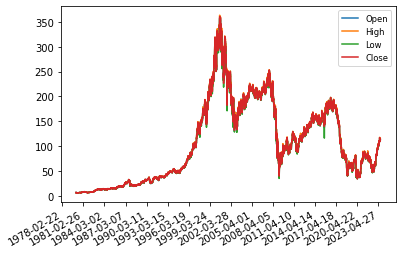

In [10]:
#Test, for understanding the pattern
import matplotlib.dates as mdates
labels = list(df_test)[1:5]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1100))
plt.plot(df_test["Date"],df_test.iloc[:, 1:5],label = labels)
plt.gcf().autofmt_xdate()
plt.legend(fontsize="small")
plt.show()

#As you can see GE was vibin in early 2000s

In [11]:
label = list(df_test)[1:5]
label

['Open', 'High', 'Low', 'Close']

In [12]:
#Now we need to scale  the features for all the columns.

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset

scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled

array([[-1.21575462, -1.21612648, -1.21691741, -1.21700202, -1.26785857],
       [-1.21730895, -1.21497341, -1.21652434, -1.21408806, -1.26658337],
       [-1.21439461, -1.21305161, -1.21593473, -1.2160307 , -1.26743351],
       ...,
       [ 0.10460991,  0.09904422,  0.09328181,  0.07791247,  0.74895542],
       [ 0.08286732,  0.07950415,  0.08322746,  0.08946561,  0.76615669],
       [ 0.09653417,  0.10297682,  0.10748371,  0.11418681,  0.80296368]])

In [13]:
# We will have a sliding window of size 14 and predict the 15th day and move by 1 day each

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14    # Number of past days we want to use to predict the future.

In [14]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (10988, 5)
#10988 refers to the number of data points and 5 refers to the columns (multi-variables).

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
    
#df_for_training.shape[1] = 5
#For trainX ==> From 14 days back to the current -1 day. Column from 0 to 4 as 5 is not inc.
#For trainY ==> On current day

In [15]:
print(len(trainX))
print(trainX[0].shape)
# So for each 10974, we have 14,5 matrix

10974
(14, 5)


In [16]:
#Convert them to array
trainX, trainY = np.array(trainX), np.array(trainY)
print(trainX.shape)
print(trainY.shape)

(10974, 14, 5)
(10974, 1)


In [17]:
%store trainX
%store trainY
%store n_future
%store n_past
%store train_dates
%store df_for_training
%store scaler
%store df

Stored 'trainX' (ndarray)
Stored 'trainY' (ndarray)
Stored 'n_future' (int)
Stored 'n_past' (int)
Stored 'train_dates' (Series)
Stored 'df_for_training' (DataFrame)
Stored 'scaler' (StandardScaler)
Stored 'df' (DataFrame)


#### NOTE:
In my case, trainX has a shape (10974, 14, 5). 
12809 because we are looking back 14 days (10988 - 14 = 10974). 
Remember that we cannot look back 14 days until we get to the 15th day. 


Also, trainY has a shape (10974, 1). Our model only predicts a single value, but 
it needs multiple variables (5 in my example) to make this prediction. 
This is why we can only predict a single day after our training, the day after where our data ends.


To predict more days in future, we need all the 5 variables which we do not have. 
We need to predict all variables if we want to do that. 
